In [1]:
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

import os
import pandas as pd
import numpy as np
import pickle as pk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_1samp


Bad key "text.kerning_factor" on line 4 in
C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Define stoploss and take profit
stoploss = .05
takeprofit = .12
list_nPCs = [10, 15, 20, 25, 30, 35, 40]
fees = 0.001 # 0.1% fee structure for portfolio management

# Bring in data and define number of trades
nTrades_mini = 100 # minimal number of trades we want over the test set: this is for second approach

trainset_final = pd.read_csv('./Data/Trainset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit))
trainset = pd.read_csv('./Data/Trainset_SL{}_TP{}.csv'.format(stoploss, takeprofit))

validation_set_final = pd.read_csv('./Data/Validationset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit))
validation_set = pd.read_csv('./Data/Validationset_SL{}_TP{}.csv'.format(stoploss, takeprofit))

testset_final = pd.read_csv('./Data/Testset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit))
testset = pd.read_csv('./Data/Testset_SL{}_TP{}.csv'.format(stoploss, takeprofit))

In [3]:
# Hotfix function
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

def make_keras_picklable():
    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))
    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

In [4]:
# compute wins and losses
def compute_earnings_loss(stoploss, takeprofit, fees):
    # Compute earnings and losses
    win = (1-fees)*(1+takeprofit)*(1-fees) -1
    loss = (1-fees)*(1-stoploss)*(1-fees) -1
    return(win, loss)

In [5]:
def predict_and_backtest_bullish(df, df_final, model, stoploss, takeprofit, fees, plotting = True):
    # Compute predictions on testset
    df['preds'] = (clf.predict(df_final.iloc[:, :nPCs]) > 0.5)*1
    df['proba1'] = clf.predict(df_final.iloc[:, :nPCs])

    # keep only the timesteps in which the model predicts a bullish trend
    testset1 = df[df['preds'] == 1].copy()

    # Compute earnings column
    a = compute_earnings_loss(stoploss, takeprofit, fees)
    testset1['EarningsBullish'] = (testset1['preds'] == testset1['result'])*a[0] + (testset1['preds'] != testset1['result'])*a[1]

    if plotting:
        # Now plot our trading strategy
        plt.plot(pd.to_datetime(testset1['date']), np.cumsum(testset1['EarningsBullish']))
        plt.title('Approach over the test set \n ROI = {} %'.format(100*np.mean(testset1['EarningsBullish'])))
        plt.xlabel('Date')
        plt.xlabel('Cumulative Earnings')
        plt.show()

        # Display the entry points
        plt.plot(pd.to_datetime(df['date']), df['close'])
        plt.scatter(pd.to_datetime(testset1['date']), testset1['close'], c = (testset1['EarningsBullish']>0))
        plt.title('Entry points \n Yellow = Win, Blue = Loss')
        plt.show()

    return(testset1)

C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


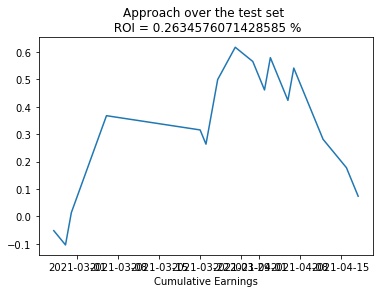

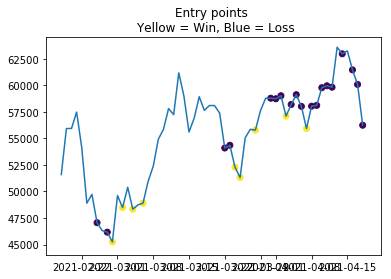

Our model has an average ROI of 0.2634576071428585 %, while trading blindly bullish over the same period yielded a ROI of -1.2311677000000005 %, when we perform statistical testing of difference there is a p-value of 0.33571169078846796.


In [6]:
# (b) Basic strategy : pick the best model and bet on bullish trends over the testset
recap = pd.read_csv('./Results/Comparative_All_models_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit)).sort_values('Accuracy', ascending = False)
nPCs = recap['nPCs'].iloc[0]

with open("./Models/DL_model_{}PC_stoploss{}_takeprofit{}.pkl".format(nPCs, stoploss, takeprofit), 'rb') as f:
    clf = pk.load(f)
testset1 = predict_and_backtest_bullish(testset, testset_final, clf, stoploss, takeprofit, fees, plotting = True)

# Assess the performance by comparing to if we always traded bullish blindly over the period
a = compute_earnings_loss(stoploss, takeprofit, fees)
testset_benchmark = testset.copy()
testset_benchmark['EarningsBullish'] = (testset['result'] == 1)*a[0] + (testset['result'] == 0)*a[1]
avg_return_benchmark = np.mean(testset_benchmark['EarningsBullish'])

# Now let's look at our approach's performance and std
p_value = ttest_1samp(testset1['EarningsBullish'], popmean = avg_return_benchmark)[1]
print('Our model has an average ROI of {} %, while trading blindly bullish over the same period yielded a ROI of {} %, when we perform statistical testing of difference there is a p-value of {}.'.format(100*np.mean(testset1['EarningsBullish']), 100*avg_return_benchmark, p_value))